In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import leidenalg as la

## Data Pre-processing

In [2]:
df = pd.read_csv("data/result.csv")
df.shape

(212966, 6)

In [3]:
df = df.sort_values('percentage',ascending=False)
df = df.reset_index(drop=True)
df.head()

,src,dst,count,type,followers,percentage
0,露娜Luna_Official,露米Lumi_Official,830,fans,994,0.83501
1,虞莫MOMO,莞儿睡不醒,818,fans,1036,0.78958
2,伊菲不是小火驴,宣小纸不怕火,652,fans,836,0.77990
3,伊菲不是小火驴,卡缇娅也不知道鸭,642,fans,836,0.76794
4,柚恩不加糖,露早GOGO,807,fans,1094,0.73766


In [4]:
## Add src's & dst's mid information
df_info = pd.read_csv("data/streamer_info.csv")
df_info = df_info[['uname','mid']]

df = pd.merge(df,df_info,how='left',left_on='src',right_on='uname')
df = pd.merge(df,df_info,how='left',left_on='dst',right_on='uname')

## Calculate the reverse of percentage from dst to src
dict_followers = dict(zip(df.src, df.followers))
df['followers_dst'] = df['dst'].map(dict_followers)
df['percentage_reverse'] = df.apply(lambda x: round(x['count'] / dict_followers[x['dst']],3), axis=1)

## Rename columns
df = df[['src', 'dst', 'count', 'type', 'followers', 'percentage', 'percentage_reverse', 'mid_x', 'mid_y','followers_dst']]
df.head()

,src,dst,count,type,followers,percentage,percentage_reverse,mid_x,mid_y,followers_dst
0,露娜Luna_Official,露米Lumi_Official,830,fans,994,0.83501,0.177,1908273021,2000609327,4684
1,虞莫MOMO,莞儿睡不醒,818,fans,1036,0.78958,0.251,1811071010,1875044092,3254
2,伊菲不是小火驴,宣小纸不怕火,652,fans,836,0.77990,0.233,43156010,3461582034045213,2798
3,伊菲不是小火驴,卡缇娅也不知道鸭,642,fans,836,0.76794,0.159,43156010,1011797664,4046
4,柚恩不加糖,露早GOGO,807,fans,1094,0.73766,0.565,1795147802,1669777785,1428


In [5]:
# df.to_csv("dataAllUNeed.csv",index=False)

## Community Detection

In [6]:
df.describe()

,count,followers,percentage,percentage_reverse,mid_x,mid_y,followers_dst
count,212966.000000,212966.000000,212966.000000,212966.000000,2.129660e+05,2.129660e+05,212966.000000
mean,42.187983,3796.710442,0.019759,0.019756,3.216832e+13,3.216832e+13,3796.710442
std,133.179691,6041.238832,0.041756,0.041758,3.323161e+14,3.323161e+14,6041.238832
min,1.000000,29.000000,0.000020,0.000000,3.295000e+03,3.295000e+03,29.000000
25%,2.000000,686.000000,0.001700,0.002000,4.718291e+06,4.718291e+06,686.000000
50%,9.000000,1740.000000,0.005330,0.005000,1.346374e+08,1.346374e+08,1740.000000
75%,32.000000,4140.000000,0.018630,0.019000,6.906087e+08,6.906087e+08,4140.000000
max,9001.000000,51360.000000,0.835010,0.835000,3.493091e+15,3.493091e+15,51360.000000


In [7]:
## Data selection
data = df[(df['followers']>2000) & (df['followers_dst']>2000)]
data = data[(data['count']>20)]
data = data[(data['percentage']>0.05)]
# data = data[(data['percentage']>0.05) & (data['percentage_inv']>0.05)]
# data = data[(data['percentage']>0.05) | (data['percentage_inv']>0.05)]
data = data[['src','dst','count','percentage']]
data

,src,dst,count,percentage
8,老实憨厚的子衿,老实憨厚的笑笑,1479,0.71174
10,贝拉kira,嘉然今天吃什么,5959,0.68882
20,薇Steria,内德维德,1517,0.65985
24,向晚大魔王,嘉然今天吃什么,6202,0.64510
27,乃琳Queen,嘉然今天吃什么,5775,0.62840
...,...,...,...,...
21824,兰音Reine,艾尔莎_Channel,196,0.05008
21825,星汐Seki,泰蕾莎Channel,308,0.05008
21826,烛灵儿Hikari,呜米,261,0.05007
21832,小可学妹,夏川玥玥Official,292,0.05002


In [8]:
## Create graph
print("Number of nodes: ", len(data['src'].unique()))
tuples = [tuple(x) for x in data[['src','dst','percentage']].values]
Gm = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['percentage'])

Number of nodes:  182


In [9]:
## Show graph
ig.plot(Gm, bbox = (300, 300), vertex_label_dist=1, vertex_label_size=8,
        vertex_size=4, vertex_color=['red'],
        edge_width=0.5, edge_arrow_size=0.5, edge_arrow_width=0.5)
        

In [10]:
## Clustering by Modularity
partition = la.find_partition(Gm, la.ModularityVertexPartition)
# partition = la.find_partition(Gm, la.ModularityVertexPartition, max_comm_size=10)
# partition = la.find_partition(Gm, la.CPMVertexPartition, resolution_parameter = 0.65) 
print(partition)

Clustering with 187 elements and 10 clusters
[ 0] 烤鱼子Official, 少年Pi, 中国BOY超级大猩猩, 某幻君, 文韬Stefan, 蒲熠星, 花少北丶, Yommyko, C酱です,
     黄子弘凡-Lars, Asaki大人, 花花Haya, 瓶子君152, 温柔的安酱, 凉哈皮, 老番茄, 棉花大哥哥, 大祥哥来了, 神奇陆夫人,
     龙哥哥今天又鸽了, 血狼破军, 月隐空夜, 魔法Zc目录, LexBurner, 木糖纯Official, 小绝, EdmundDZhang,
     飙黑车的司机, KB呆又呆, 泛式, 依然小智, 黑桐谷歌, 逍遥散人, 卡特亚, sh7adow, OldBa1, 老骚豆腐, 清歌清歌-,
     痒局长, 守护茶茶, 猫神辣椒酱, 两仪滚, 小深深儿, 狗狗狗雨, -纯黑-, 泪腺战士, 冯提莫, 菠萝赛东°, 雷雨Lyy, 自由魂儿儿儿,
     小霖QL, 飞社长, 你的影月月
[ 1] 薇Steria, 呜米, 咩栗, 宣小纸不怕火, 卡缇娅也不知道鸭, 帅比笙歌超可爱OvO, 红晓音Akane, 东爱璃Lovely,
     奈奈莉娅Channel, 雪狐桑, 秋凛子Rinco, 星汐Seki, 勾檀Mayumi, 艾露露Ailurus, 小柔Channel,
     星弥Hoshimi, 黎歌Neeko, 杜松子_Gin, 扇宝, 蕾尔娜Leona, 路希维德Wiede, 桃几OvO, 希月萌奈,
     巴老师的小号, 雪绘Yukie, 穆小泠Official, 有棵里里, 夏川玥玥Official, 艾尔莎_Channel, 早凉,
     黑泽诺亚NOIR, 小铃久绘Official, 梦音茶糯, 奈姬niki, 兰音Reine, 陆鳐LuLu, 还有醒着的么, 折原露露,
     冥冥meichan, 泰蕾莎Channel, 不稳定发电机, 烛灵儿Hikari
[ 2] 乙女音Official, 古守血遊official, 眞白花音_Official, 鈴宮鈴, 椎名菜羽Official, 魔狼咪莉娅,
     夢乃栞Yumeno_Shiori, 雫るる_Official, 泠鸢yousa, hanser, 九重紫Off

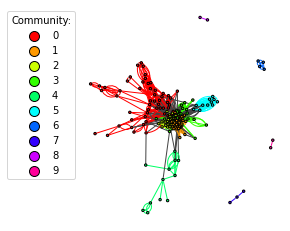

In [11]:
## Draw graph with clustering
def plot_graph(g, communities):
    num_communities = len(communities)
    palette = ig.RainbowPalette(n=num_communities)
    for i, community in enumerate(communities):
        g.vs[community]["color"] = i
        community_edges = g.es.select(_within=community)
        community_edges["color"] = i
    
    fig, ax = plt.subplots()
    ig.plot(
        communities,
        palette=palette,
        edge_width=1,
        target=ax,
        vertex_size=0.3,
    )
    # Create a custom color legend
    legend_handles = []
    for i in range(num_communities):
        handle = ax.scatter(
            [], [],
            s=100,
            facecolor=palette.get(i),
            edgecolor="k",
            label=i,
        )
        legend_handles.append(handle)
    ax.legend(
        handles=legend_handles,
        title='Community:',
        bbox_to_anchor=(0, 1.0),
        bbox_transform=ax.transAxes,
    )
    plt.show()

plot_graph(Gm, partition)

### More fine-grained clustering

In [12]:
## Clustering by CPM (Community Preserving Modularity) using optimiser
optimiser = la.Optimiser()
profile = optimiser.resolution_profile(Gm, la.CPMVertexPartition, resolution_range=(0,1))

576it [00:03, 155.69it/s, resolution_parameter=0.000977]


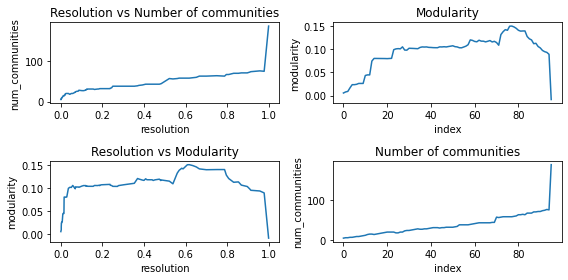

Number of communities:  96


In [13]:
def CPM_summary(profile):
    '''function to plot the summary of CPM clustering
    profile: the profile of CPM clustering,
    return: a dictionary of the summary
        - 'resolution': the resolution parameter
        - 'num_communities': the number of communities
        - 'modularity': the modularity, must be y-axis
        - 'index': the index of the profile'''

    num_communities = [len(p) for p in profile]
    modularity = [p.modularity for p in profile]
    resolution = [p.resolution_parameter for p in profile]
    index = list(range(len(profile)))
    dict_summary = {'index': index,
                    'num_communities':num_communities, 'modularity':modularity, 'resolution':resolution,}

    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(8, 4)
    axs[0, 0].plot(resolution, num_communities)
    axs[0, 0].set(xlabel='resolution', ylabel='num_communities')
    axs[0, 0].set_title('Resolution vs Number of communities')
    axs[0, 1].plot(index, modularity)
    axs[0, 1].set_title('Modularity')
    axs[0, 1].set(xlabel='index', ylabel='modularity')
    axs[1, 0].plot(resolution, modularity)
    axs[1, 0].set_title('Resolution vs Modularity')
    axs[1, 0].set(xlabel='resolution', ylabel='modularity')
    axs[1, 1].plot(index, num_communities)
    axs[1, 1].set_title('Number of communities')
    axs[1, 1].set(xlabel='index', ylabel='num_communities')
    plt.tight_layout()
    plt.show()

    print("Number of communities: ", len(profile))
    return dict_summary

summary = CPM_summary(profile)

In [14]:
## Select the best partition
# partition = profile[68] # manually select
partition = profile[summary['modularity'].index(max(summary['modularity']))]
print(f"resultion: {round(partition.resolution_parameter,4)}, modularity: {round(partition.modularity,5)}")
print(partition)

resultion: 0.618, modularity: 0.1508
Clustering with 187 elements and 58 clusters
[ 0] 呜米, 咩栗, 卡缇娅也不知道鸭, 小可学妹, 帅比笙歌超可爱OvO, 红晓音Akane, 东爱璃Lovely, 奈奈莉娅Channel,
     雪狐桑, 秋凛子Rinco, 星汐Seki, 艾露露Ailurus, 小柔Channel, 黎歌Neeko, 杜松子_Gin, 扇宝, 冰糖IO,
     蕾尔娜Leona, 路希维德Wiede, 早稻叽, 希月萌奈, 巴老师的小号, 雪绘Yukie, 白神遥Haruka, 穆小泠Official,
     有棵里里, 夏川玥玥Official, 早凉, 小铃久绘Official, 梦音茶糯, 奈姬niki, 兰音Reine, 陆鳐LuLu,
     还有醒着的么, 折原露露, 冥冥meichan
[ 1] 乙女音Official, 古守血遊official, 眞白花音_Official, 鈴宮鈴, 椎名菜羽Official, 魔狼咪莉娅,
     夢乃栞Yumeno_Shiori, HiiroVTuber, 雫るる_Official, 泠鸢yousa, 九重紫Official,
     绯赤艾莉欧_NHOTBOT, 夏诺雅_shanoa, 花园Serena, 美月もも, 星宮汐Official, 物述有栖Official,
     神楽Mea_NHOTBOT, 花丸晴琉Official, 猫芒ベル_Official, 恋乃夜舞_propro, 茉吱Mojuko
[ 2] 贝拉kira, 嘉然今天吃什么, 向晚大魔王, 乃琳Queen, 阿梓从小就很可爱, 七海Nana7mi, 明前奶绿, 永雏塔菲,
     星瞳_Official, 莞儿睡不醒, 啵啵小狗341
[ 3] 舒三妈Susam, 阿萨Aza, 张恩恩NNN, 尤格Yog, 罗伊_Roi, 杜铂雷Dobre, 虚拟小萨, 凛-阿格里亚斯, 塔克Tako
[ 4] 花花Haya, 瓶子君152, 月隐空夜, 木糖纯Official, 艾尔莎_Channel, 泛式, 依然小智
[ 5] 中国BOY超级大猩猩, 某幻君, 花少北丶, 老番茄, LexBurner, KB呆又呆

## Save the clustering result

In [15]:

## Gererate a dictionaries for mapping node name to node id
name_map = {}
group_map = {}

### get name of each node
for v in Gm.vs():
    idx = v.index
    name = v.attributes()['name']
    name_map[idx] = name

name_map_reverse = dict((v,str(k)) for k,v in name_map.items())

# list map映射
# list(map(lambda x: name_map[x], partition[0]))

### Mapping
for group_id, group in enumerate(partition):
    for member in group:
        group_map[name_map[member]] = str(group_id+1)

In [16]:
df['category'] = df.src.map(group_map)

In [17]:
## Create dataframe for nodes data and edges data

### Node dataframe
df_node = df[df['category'].notna()][['src','followers','category']].drop_duplicates()
df_node['id'] = df.src.map(name_map_reverse)
# df_node = df_node.reset_index(drop=True)
df_node = df_node[['id','src','followers','category']]
df_node.columns = ['id','name','value','category']
df_node

,id,name,value,category
8,0,老实憨厚的子衿,2078,26
10,2,贝拉kira,8651,3
20,4,薇Steria,2299,7
24,6,向晚大魔王,9614,3
27,7,乃琳Queen,9190,3
...,...,...,...,...
25346,164,longdd黄翔,8490,39
28860,183,CSGO--德云两鬼,13168,54
33516,180,__小黄瓜__,5340,51
36995,1,老实憨厚的笑笑,50010,27


In [18]:
### Edge dataframe
df_edge = df[df['category'].notna()][['src','dst','percentage']].drop_duplicates()
df_edge['source'] = df_edge.src.map(name_map_reverse)
df_edge['target'] = df_edge.dst.map(name_map_reverse)
df_edge = df_edge[['source','target','percentage','src','dst']]
df_edge.columns = ['source','target','weight','src','dst']
df_edge = df_edge[df_edge['target'].notna()]
df_edge

,source,target,weight,src,dst
8,0,1,0.71174,老实憨厚的子衿,老实憨厚的笑笑
10,2,3,0.68882,贝拉kira,嘉然今天吃什么
20,4,5,0.65985,薇Steria,内德维德
24,6,3,0.64510,向晚大魔王,嘉然今天吃什么
27,7,3,0.62840,乃琳Queen,嘉然今天吃什么
...,...,...,...,...,...
212362,22,39,0.00006,眞白花音_Official,黄子弘凡-Lars
212363,22,173,0.00006,眞白花音_Official,西安WE丶Best
212364,29,53,0.00006,蒲熠星,夏诺雅_shanoa
212446,68,55,0.00005,凉哈皮,dodo_Official


In [19]:
## Save to csv
df_edge.to_csv('data/edges.csv',index=False)
df_node.to_csv('data/nodes.csv',index=False)